In [ ]:
using CavityTools, ProgressMeter, IndexedGraphs, Graphs
using MatrixProductBP, MatrixProductBP.Models

λ = 0.2

γ = 0.9      # prob. of zero patient
ρ = 0.1       # rate of recovery
α = 0.0

k = 3
T = 10^7

N = 2000
Δt = 1.0
seed = 0
gg = random_regular_graph(N, k; seed)
g = IndexedGraph(gg)
#sis = SIS(g, λ, ρ, T; γ)
P0 = fill(γ, N)
K = ceil(Int, T/Δt)+1


function getstats(Δt, K)
    p = Progress(K; dt=1)
    ni = zeros(Int, K)

    function stats(t, i, x)
        k = ceil(Int, t/Δt)
        update!(p, k)
        ni[k + 1] += 2x[i]-1
    end
end

stat = getstats(Δt, K)

simulate_queue_sis!(falses(N), g, P0, λ, ρ, α, T; stats=stat);

Progress:  72%|█████████████████████████████▋           |  ETA: 0:13:30Excessive output truncated after 524411 bytes.

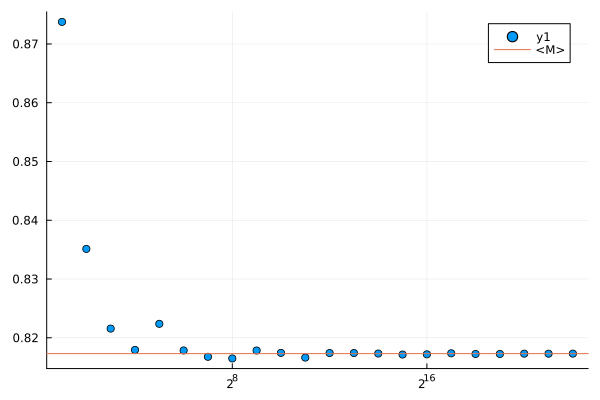

In [15]:
X = cumsum(stat.ni) ./ N



function blockmean(X)
    N = length(X)
    @showprogress map(1:floor(Int, log2(N))-1) do i 
        @views sum(X[2^i:2^(i+1)-1])/2^i
    end
end

therm = blockmean(X)

using Plots

scatter(2 .^ eachindex(therm), therm, xscale=:log2)
hline!([sum(X[end÷2:end])/length(X[end÷2:end])], label="<M>")


In [16]:
therm

22-element Vector{Float64}:
 0.87375
 0.8351249999999999
 0.8215625
 0.8179375
 0.8223750000000001
 0.8178437500000001
 0.816765625
 0.816484375
 0.8178349609375003
 0.8174296875000001
 ⋮
 0.8173196716308595
 0.8171470947265627
 0.8171848373413086
 0.817357666015625
 0.8172431983947754
 0.8172473888397217
 0.8172961454391481
 0.817292179107666
 0.8173031224012376

In [17]:

dts = 1:5:200
M = @view X[end÷2:end]
M2 = sum(x->x^2, M)/length(M)
M1 = sum(M)/length(M)
corr = map(dts) do dt
    n = length(M)-dt
    Mtdt = @views sum(M[dt+1:end])/n
    Mt = @views sum(M[1:end-dt])/n
    C = @inbounds sum((M[t+dt]-Mtdt)*(M[t]-Mt)/n for t=1:n)
    C/(M2-M1^2)
end;



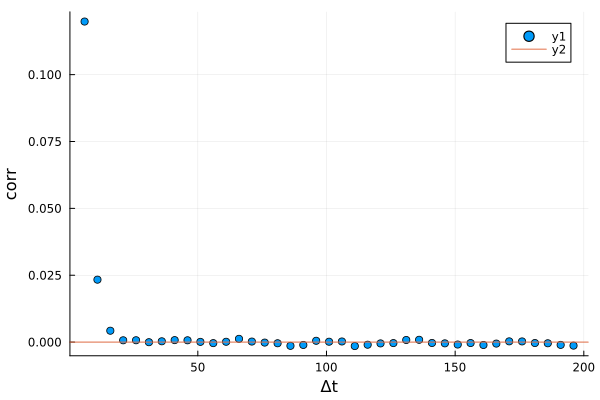

In [21]:
scatter(dts[2:40], corr[2:40], xlabel="Δt", ylabel="corr")
hline!([0])

In [23]:
M1, √(M2-M1^2)/√(length(M)/25)

(0.8173073406770637, 2.2305098718432718e-5)

0.590524372390251